# 02_DiD_estimates.ipynb

In [22]:
from differences import ATTgt
import figure_utilities
from analysis_utilities import produce_summary_statistics
import figure_and_table_constants
from matplotlib import pyplot as plt
from scipy import stats

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

In [23]:
# Create dictionaries to map between string represetation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

In [35]:
# TODO: Build balance table of pretreatment characteristics.
treated_obs = df.copy().loc[df['judgment_for_plaintiff'] == 1, :]
control_obs = df.copy().loc[df['judgment_for_plaintiff'] == 0, :]

# Build treatment, control mean columns and add recoded variables to treatment and control DataFrames in memory.
pd.options.mode.chained_assignment = None
# Return treatment means and add covariate columns to the treatment D.F. in memory.
treatment_means = produce_summary_statistics(treated_obs, 'file_date').loc[["Panel A: Case Initiation",
                                                                        "Panel C: Defendant and Plaintiff Characteristics",
                                                                        "Panel D: Assessor Records From Most Recent Pre-Filing F.Y."], 'mean']
treatment_means = treatment_means.rename("Cases Won by Plaintiff")
# Return control means and add covariate columns to the control D.F. in memory.
control_means = produce_summary_statistics(control_obs, 'file_date').loc[["Panel A: Case Initiation",
                                                                      "Panel C: Defendant and Plaintiff Characteristics",
                                                                      "Panel D: Assessor Records From Most Recent Pre-Filing F.Y."], 'mean']
pd.options.mode.chained_assignment = 'warn'

# Build unweighted columns.
difference_unadjusted = treatment_means - control_means
p_values_unadjusted = []
for covariate in treatment_means.index.get_level_values(1):
    p_values_unadjusted.append(stats.ttest_ind(treated_obs[covariate], control_obs[covariate], nan_policy='omit').pvalue)
p_values_unadjusted = pd.Series(p_values_unadjusted, index=treatment_means.index)
unweighted_columns = pd.concat([difference_unadjusted, p_values_unadjusted], axis=1)
unweighted_columns.columns = ['Unweighted', 'P-Value']
table_columns = [treatment_means, unweighted_columns]
balance_table = pd.concat(table_columns, axis=1, keys=['', 'Difference in Cases Won by Defendant'])
# Rename rows.
display_names = ["For cause", "For cause (transfer)",
                 "Foreclosure", "Foreclosure (transfer)",
                 "No cause", "No cause (transfer)",
                 "Non-payment of rent", "Non-payment of rent (transfer)",
                 "Defendant has an attorney", "Plaintiff has an attorney", "Defendant is an entity",
                 "Plaintiff is an entity", "Total property value", "Building value",
                 "Land value", "Other value", "Units", ]
variable_display_names_dict = {key: value for key, value in zip(treatment_means.index.get_level_values(1), display_names)}
balance_table = balance_table.rename(index=variable_display_names_dict)

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "balance_table.tex")
latex = (balance_table
         .style
         .format(thousands=",",
                 formatter="{:.2f}")
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .format_index("\\textit{{{}}}", escape="latex", axis=1, level=0)
         .to_latex(None,
                   column_format="llcccccc",
                   hrules=True,
                   multicol_align='c',
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
balance_table

\
                                                                                  Cases Won by Plaintiff   
Panel A: Case Initiation                           For cause                                1.196721e-01   
                                                   For cause (transfer)                     4.508197e-03   
                                                   Foreclosure                              4.303279e-02   
                                                   Foreclosure (transfer)                   8.196721e-04   
                                                   No cause                                 1.053279e-01   
                                                   No cause (transfer)                      5.737705e-03   
                                                   Non-payment of rent                      7.102459e-01   
                                                   Non-payment of rent (transfer)           1.065574e-02   
Panel C: Defendant and Plaintiff Characteristics   Defendant has an attorney                6.598361e-02   
                                                   Plaintiff has an attorney                7.959016e-01   
                                                   Defendant is an entity                   1.188525e-02   
                                                   Plaintiff is an entity                   6.594262e-01   
Panel D: Assessor Records From Most Recent Pre-... Total property value                     6.554744e+06   
                                                   Building value                           1.897711e+06   
                                                   Land value                               8.758564e+04   
                                                   Other value                              8.535626e+06   
                                                   Units                                    2.873481e+01   

                                                                                  Difference in Cases Won by Defendant  \
                                                                                                            Unweighted   
Panel A: Case Initiation                           For cause                                                  0.012446   
                                                   For cause (transfer)                                      -0.007147   
                                                   Foreclosure                                                0.027881   
                                                   Foreclosure (transfer)                                    -0.000346   
                                                   No cause                                                  -0.021712   
                                                   No cause (transfer)                                       -0.005917   
                                                   Non-payment of rent                                        0.005118   
                                                   Non-payment of rent (transfer)                            -0.010323   
Panel C: Defendant and Plaintiff Characteristics   Defendant has an attorney                                 -0.135648   
                                                   Plaintiff has an attorney                                  0.011519   
                                                   Defendant is an entity                                     0.003727   
                                                   Plaintiff is an entity                                     0.028890   
Panel D: Assessor Records From Most Recent Pre-... Total property value                                  184134.628913   
                                                   Building value                                         25986.913258   
                                                   Land value                                        

In [12]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
df = df.dropna(subset=['file_date', 'latest_docket_date'])
print(f"Limiting sample to {len(df)} evictions for which we observe the filing date and the latest docket"
      f"date.")

# Reshape from wide to long.
cases_per_year = df[treatment_year_variable].value_counts()
df = pd.melt(df,
             id_vars=['case_number', treatment_month_variable, 'judgment_for_plaintiff'],
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, treatment_month_variable] = df[treatment_month_variable].replace(month_to_int_dictionary)
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, treatment_month_variable] = np.NaN
df.loc[never_treated_mask, treatment_year_variable] = np.NaN

# Set index to entity and time.
df = df.set_index(['case_number', 'month'])

Limiting sample to 2964 evictions for which we observe the filing date and the latest docketdate.


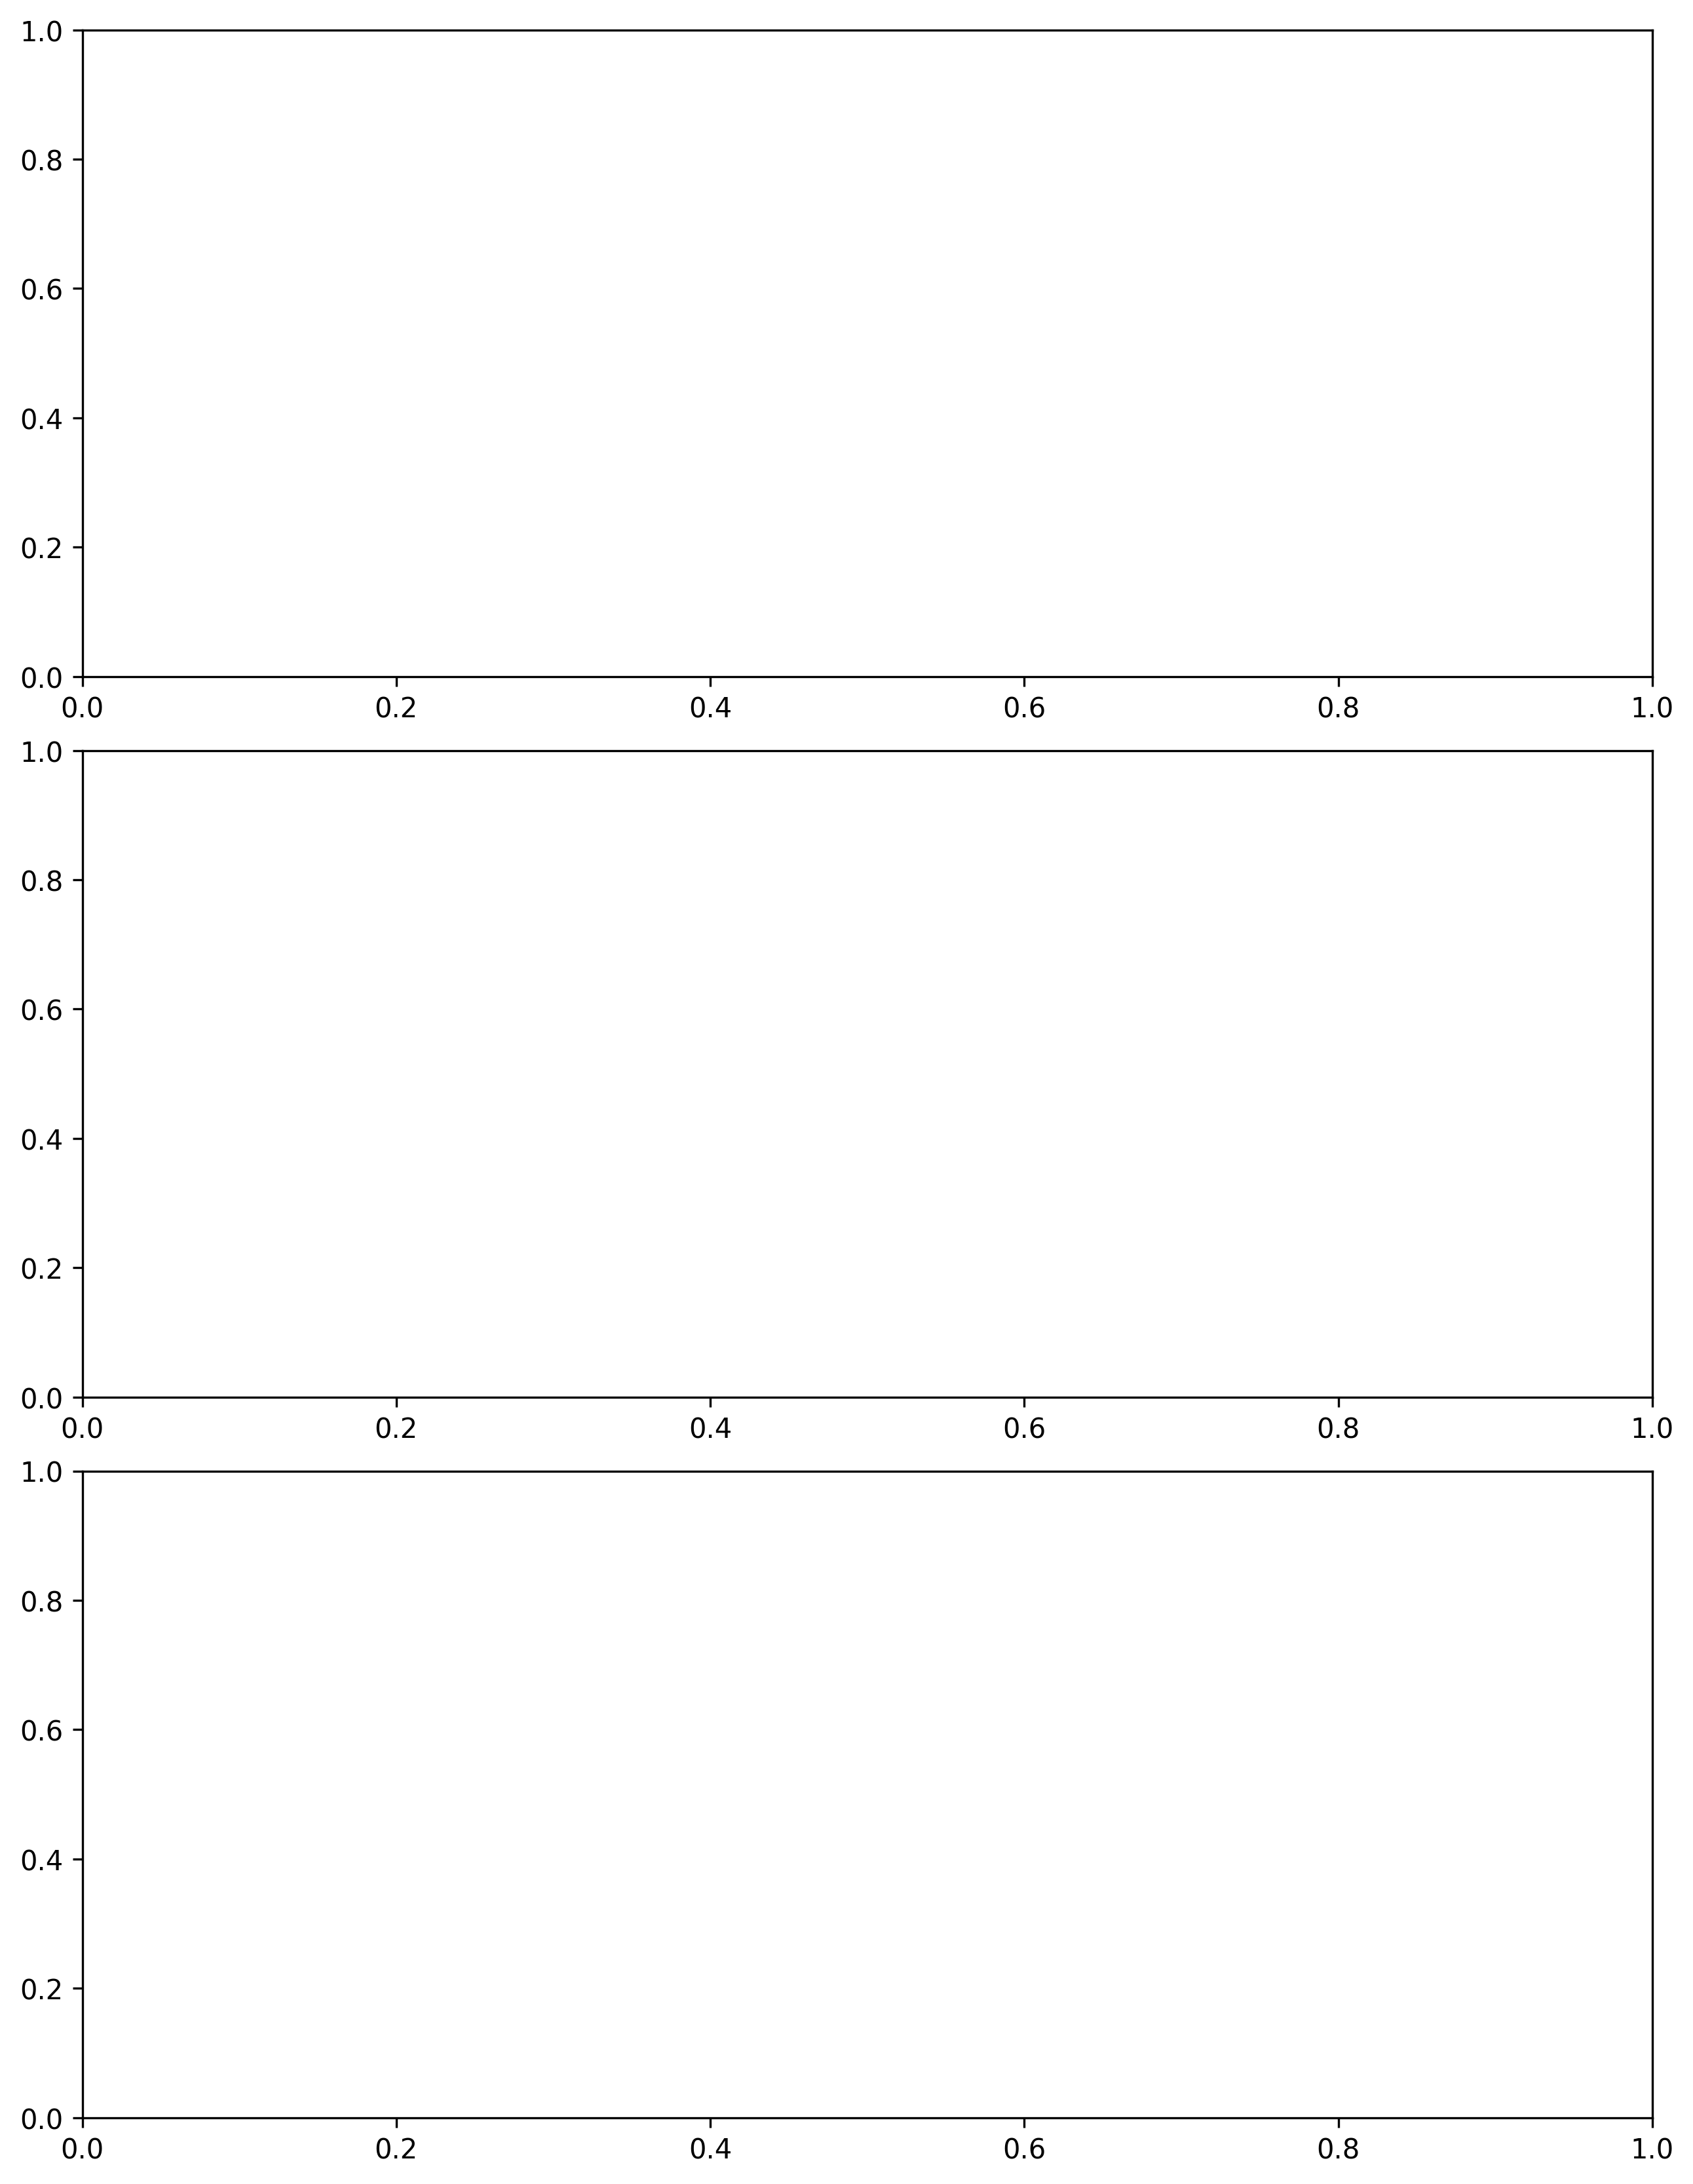

In [13]:
# Plot path of outcomes in treated group vs. control group, separately by year of filing.
# Plot.
aggregated_zestimates = (df
                         .copy().loc[(slice(None), slice(60, 120)), ]
                         .groupby([treatment_year_variable, 'month'], dropna=False)['zestimate']
                         .agg([np.mean, np.std, 'count']))
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96 * aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96 * aggregated_zestimates['se']
treatment_times = aggregated_zestimates.index.get_level_values(treatment_year_variable).unique()

fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(8.5, 11))
for ax, aggregated_cohort in zip(axes, treatment_times):
    # No need to plot trends for untreated cohort.
    if np.isnan(aggregated_cohort):
        continue
    # Shade months during which treatment occurred in each aggregated cohort.
    start_shading = 12*(int(aggregated_cohort) - 2017 - 1)
    end_shading = start_shading + 12
    ax.axvspan(start_shading, end_shading, color=figure_and_table_constants.Colors.LABELING_COLOR,
               alpha=0.25)
    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values

    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_treatment,
                                                     y_treatment,
                                                     y_upper_treatment,
                                                     y_lower_treatment,
                                                     point_color=figure_and_table_constants.Colors.TREATMENT_COLOR,
                                                     error_color=figure_and_table_constants.Colors.TREATMENT_COLOR)

    sub_df_control = (aggregated_zestimates.loc[aggregated_zestimates.index.get_level_values(treatment_year_variable)
                                                .isna(), :])
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                                     x_control,
                                                     y_control,
                                                     y_upper_control,
                                                     y_lower_control,
                                                     point_color=figure_and_table_constants.Colors.CONTROL_COLOR,
                                                     error_color=figure_and_table_constants.Colors.CONTROL_COLOR)
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.grid(True)


    ax.tick_params(axis='x', labelrotation=45)
    if treatment_date_variable == 'file_date':
        verb = 'Filed'
    elif treatment_date_variable == 'latest_docket_date':
        verb = 'Concluded'
    else:
        raise ValueError("Invalid treatment_date_variable.")
    ax.set_title(f"Eviction Cases {verb} in {aggregated_cohort}\n"
                 f"({cases_per_year.loc[int(aggregated_cohort)]} Eviction Cases)")
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates_by_cohort.png"))

In [18]:
# Run DiD.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [01:13<00:00, 40.61it/s]


In [20]:
results_df = att_gt.aggregate('event')
att_gt.wald_pre_test

TypeError: results() got an unexpected keyword argument 'sample_name'

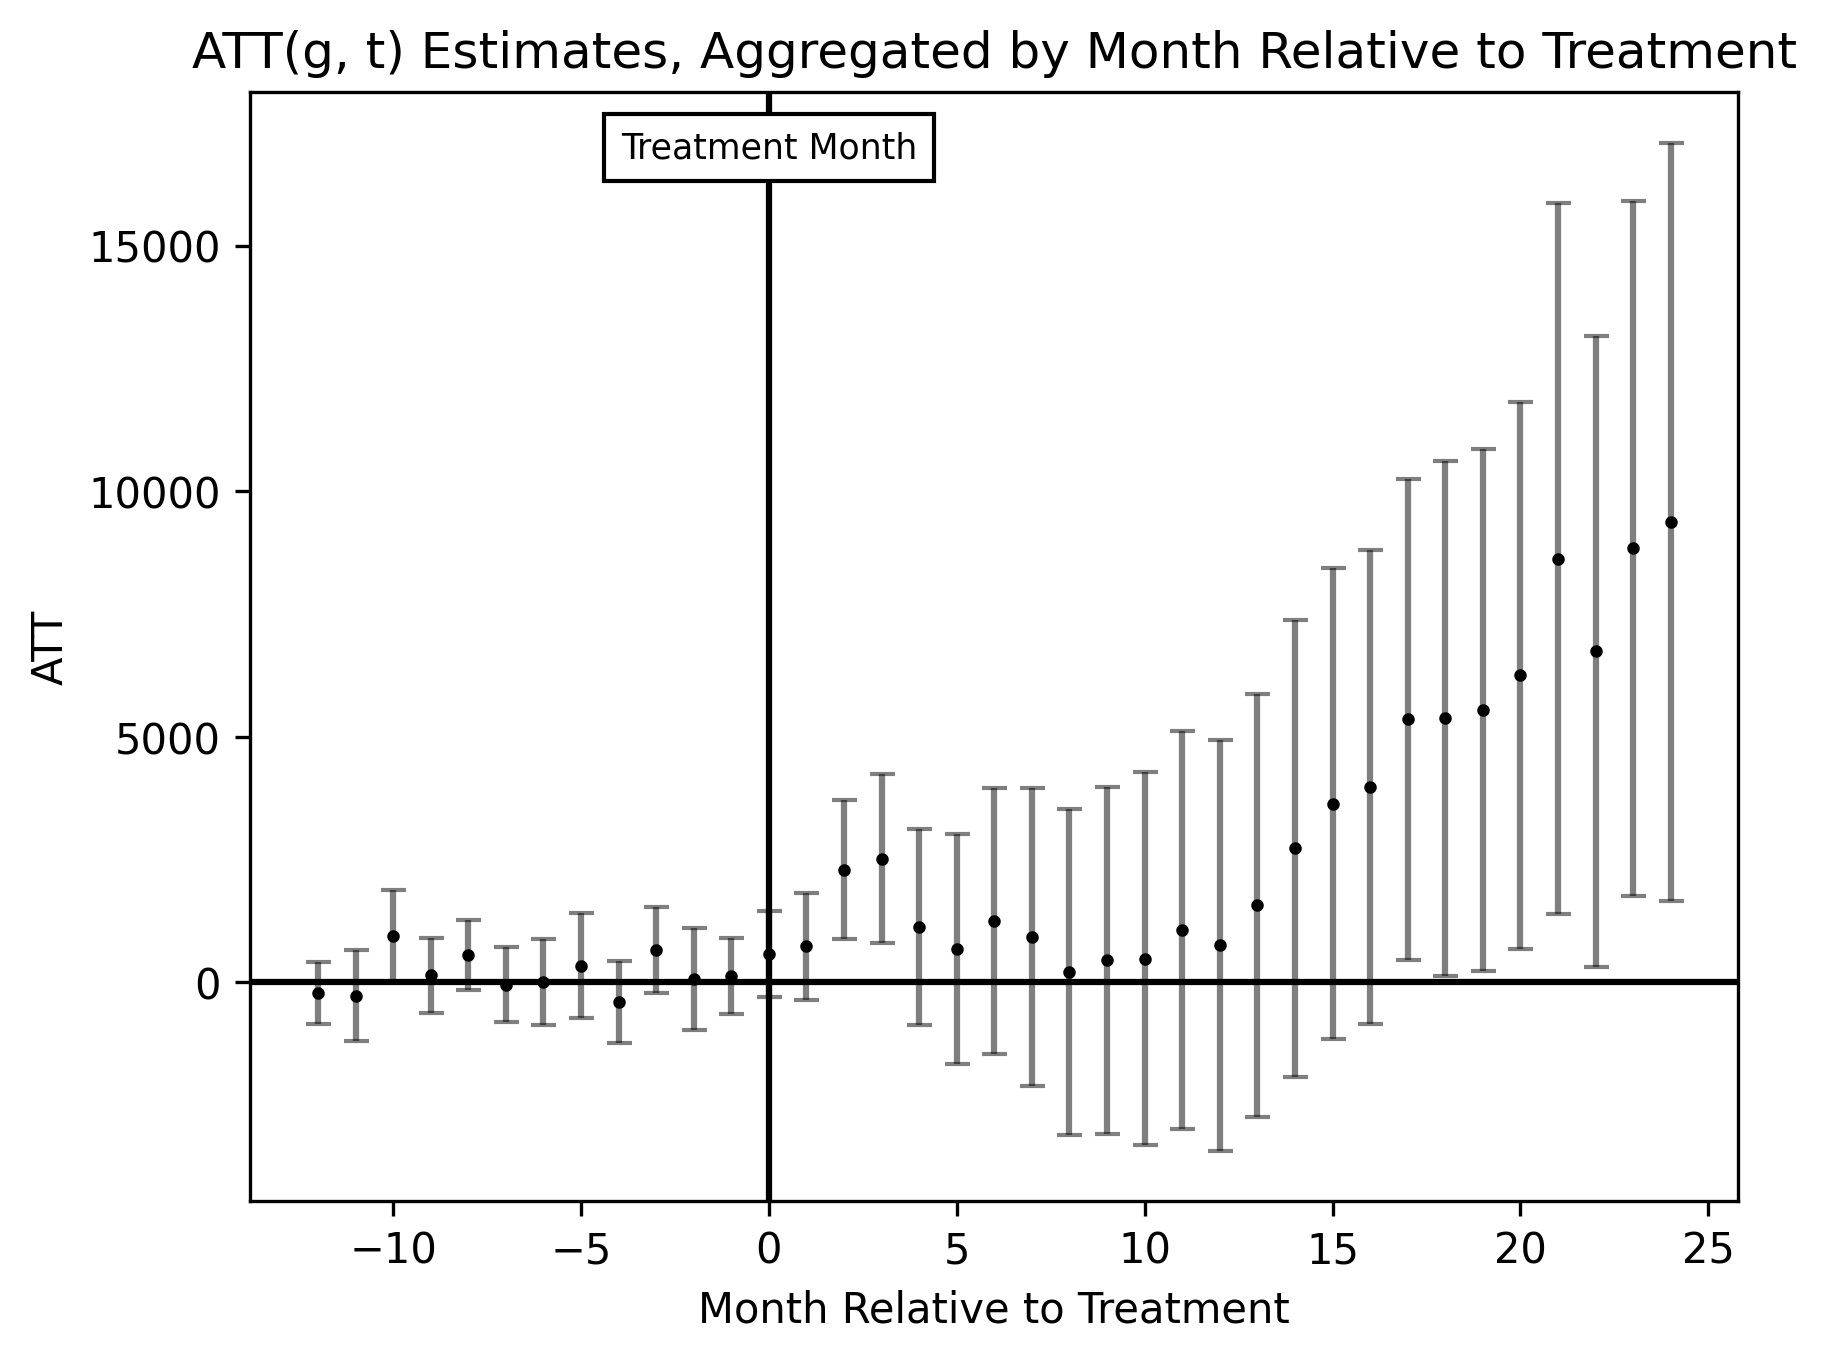

In [19]:
# Get cohort-aggregated ATT(t)s.
results_df = att_gt.aggregate('event')
results_df = results_df.loc[-12:24]
results_df.columns = results_df.columns.droplevel().droplevel()

# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
x = results_df.index
y = results_df['ATT']
y_upper = results_df['upper']
y_lower = results_df['lower']
ax.set_xlabel("Month Relative to Treatment")
ax.set_ylabel("ATT")
ax.set_title("ATT(g, t) Estimates, Aggregated by Month Relative to Treatment")
figure_utilities.plot_labeled_vline(ax, x=0, text="Treatment Month", color='black', linestyle='-',
                                    text_y_location_normalized=0.95)
figure_utilities.plot_labeled_hline(ax, y=0, text="", color='black', linestyle='-')
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower,
                                              point_color='black',
                                              error_color='black')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_estimates_event_study.png"))
